In [1]:
import deconV as dv
import scout

import glob, tqdm, time, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.express as px

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
params = {
    "jupyter": True,
    "tqdm": True,
    "cell_type_key": "cellType",
    "index_col": 0,
    "model_type": "poisson",
    "lr": 0.01,
    "epochs": 5000,
    "fig_fmt": "png",

    # "selected_ct": ["alpha", "delta", "gamma", "beta"],
    # "bulk_file": "../../data/xin/bulk.tsv",
    # "ref_annot_file": "../../data/xin/pdata.tsv",
    # "ref_file": "../../data/xin/sc.tsv",

    # "selected_ct": ["alpha", "delta", "gamma", "beta", "ductal", "acinar"],
    # "bulk_file": "../../data/pancreas/bulk.tsv",
    # "ref_annot_file": "../../data/pancreas/pdata.tsv",
    # "ref_file": "../../data/pancreas/sc.tsv",

    "selected_ct": ["alpha", "delta", "gamma", "beta", "ductal", "acinar"],
    "bulk_file": "../../data/mouse/bulk.tsv",
    "ref_annot_file": "../../data/mouse/pdata.tsv",
    "ref_file": "../../data/mouse/sc.tsv",
    
    # "selected_ct": ["0", "1", "2"],
    # "bulk_file": "../../data/GSE136148/bulk.tsv",
    # "ref_annot_file": "../../data/GSE136148/pdata.tsv",
    # "reference_file": "../../data/GSE136148/sc.tsv",
    
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [3]:
sadata = dv.tl.read_data(params["ref_file"])
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3514, genes: 26179


/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
print("Reading pheno data...")
pheno_df = pd.read_csv(params["ref_annot_file"], sep="\t", index_col=params["index_col"])
pheno_df.index.name = None

Reading pheno data...


In [5]:
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))
len(common_cells)

2038

In [6]:
sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs[params["cell_type_key"]] = pheno_df[params["cell_type_key"]].tolist()
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
acinar    185
alpha     886
beta      270
delta     114
ductal    386
gamma     197
dtype: int64

In [7]:
print("Reading bulk data...")
bulk_df = pd.read_csv(params["bulk_file"], sep="\t", index_col=0)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 7, genes: 26179


In [8]:
sadata = sadata[sadata.obs[params["cell_type_key"]].isin(params["selected_ct"]), :].copy()
sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype("category")
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
acinar    185
alpha     886
beta      270
delta     114
ductal    386
gamma     197
dtype: int64

In [9]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
scout.tl.scale_log_center(adata)

scRNA-seq data - cells: 2038, genes: 20553
bulk RNA-seq data - samples: 7, genes: 20553


In [10]:
decon = dv.DeconV(adata, label_key=params["cell_type_key"])

Added results to: adata.uns['de']['cellType']


In [11]:
sc.tl.umap(adata)
scout.ply.projection(adata, hue=params["cell_type_key"])

In [12]:
decon.adata.uns["de"]["cellType"]["alpha vs. rest"]["dispersion"].min()

0.9616218

In [13]:
decon.adata.uns["de"]["cellType"]["delta vs. rest"]["dispersion"].min()

0.86842096

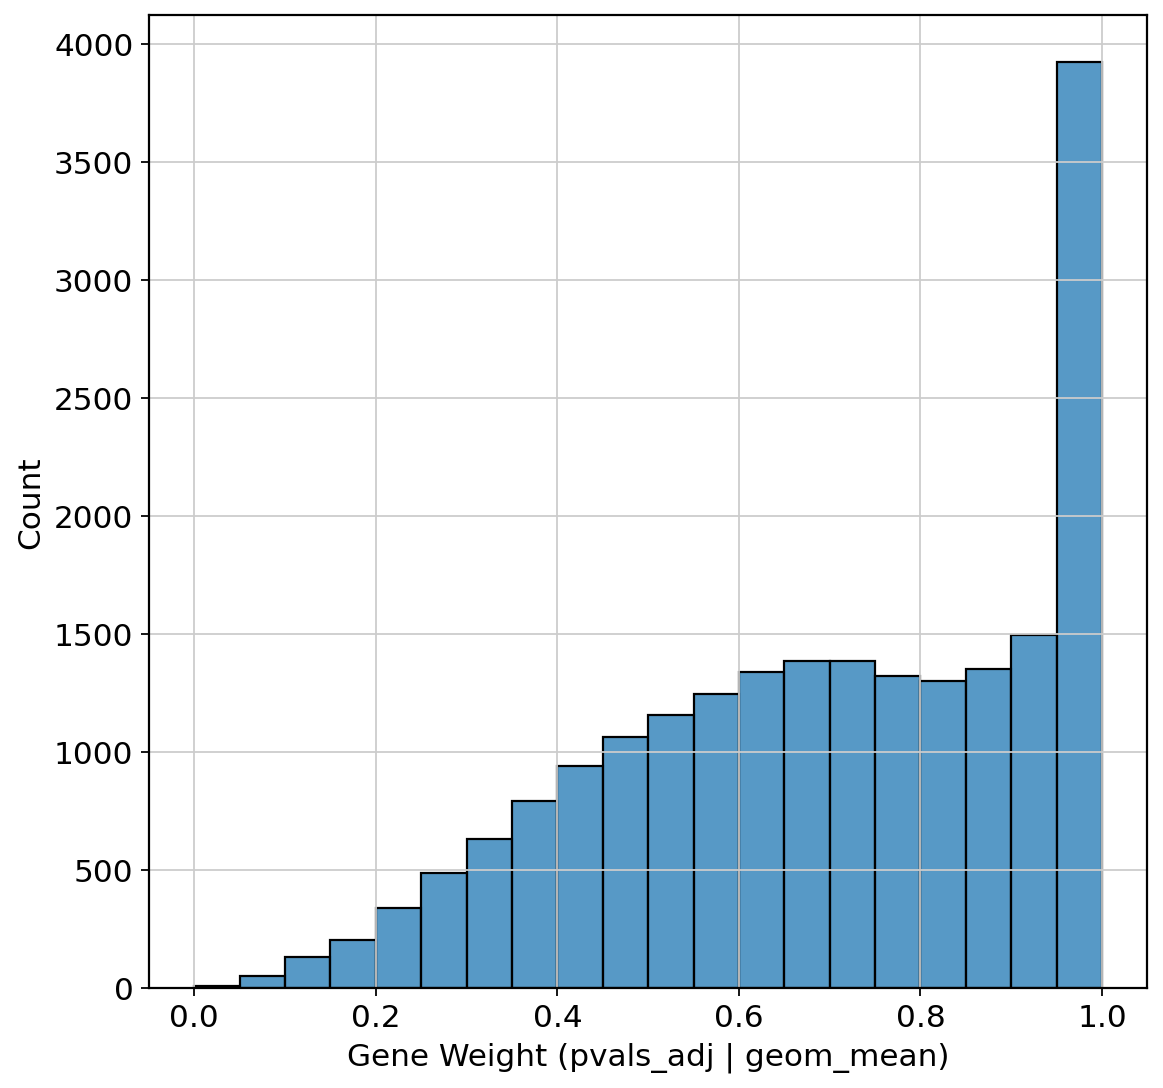

/home/lutrarutra/Documents/dev/fimm/deconv/deconV/DeconV.py:126: RuntimeWarning:

divide by zero encountered in divide



In [14]:
decon.init_dataset(use_outliers=False, weight_type="pvals_adj", weight_agg="geom_mean")

Sample: 0/7


100%|██████████| 5000/5000 [00:09<00:00, 530.51it/s, loss=22639.5, p=0.02 0.22 0.52 0.03 0.15 0.06, lib_size=90.1] 


Sample: 1/7


100%|██████████| 5000/5000 [00:07<00:00, 638.65it/s, loss=18715.6, p=0.10 0.06 0.62 0.02 0.18 0.02, lib_size=98.9] 


Sample: 2/7


100%|██████████| 5000/5000 [00:07<00:00, 655.14it/s, loss=30149.4, p=0.01 0.18 0.61 0.03 0.12 0.04, lib_size=105.0]


Sample: 3/7


100%|██████████| 5000/5000 [00:07<00:00, 647.42it/s, loss=20974.1, p=0.03 0.26 0.32 0.02 0.35 0.02, lib_size=128.1]


Sample: 4/7


100%|██████████| 5000/5000 [00:07<00:00, 665.35it/s, loss=23768.3, p=0.01 0.43 0.45 0.01 0.09 0.01, lib_size=125.3]


Sample: 5/7


100%|██████████| 5000/5000 [00:08<00:00, 570.99it/s, loss=17193.9, p=0.02 0.17 0.46 0.03 0.30 0.03, lib_size=85.0] 


Sample: 6/7


100%|██████████| 5000/5000 [00:07<00:00, 644.97it/s, loss=14796.1, p=0.02 0.39 0.22 0.01 0.34 0.01, lib_size=82.7] 


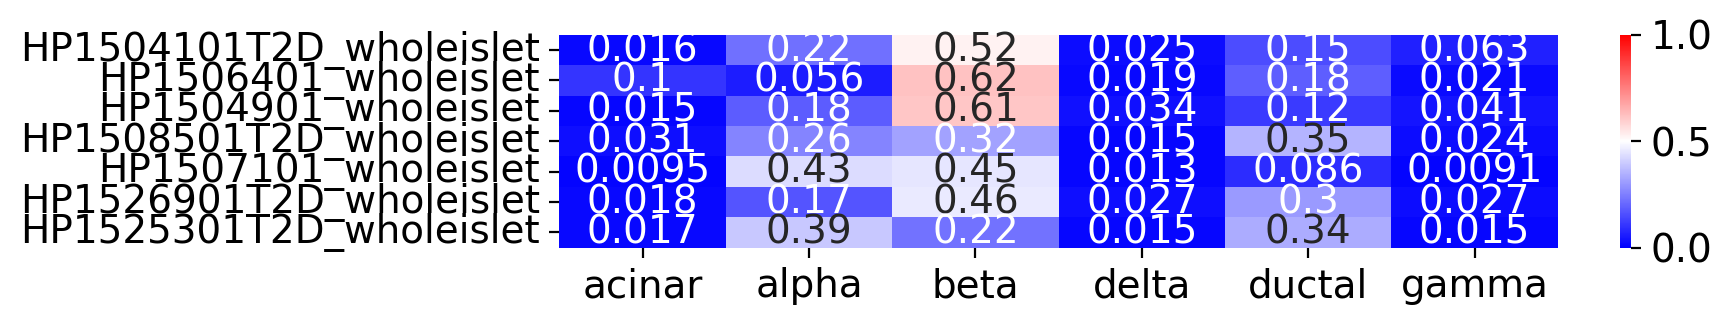

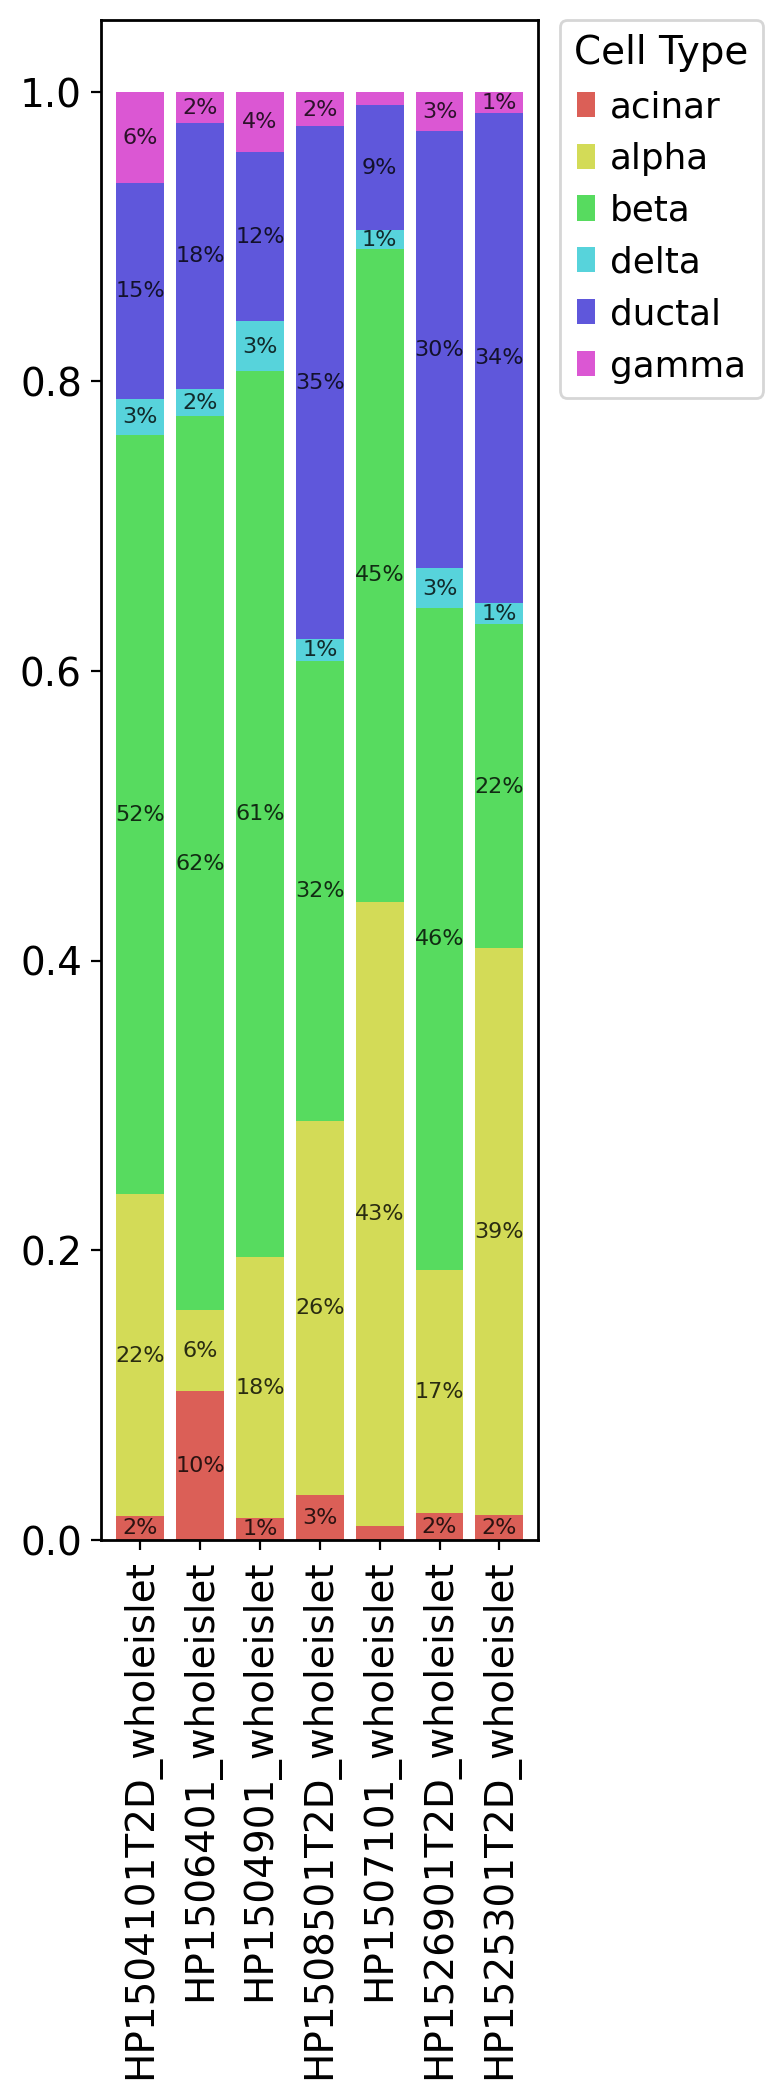

In [15]:
est_df = decon.deconvolute()

<AxesSubplot: >

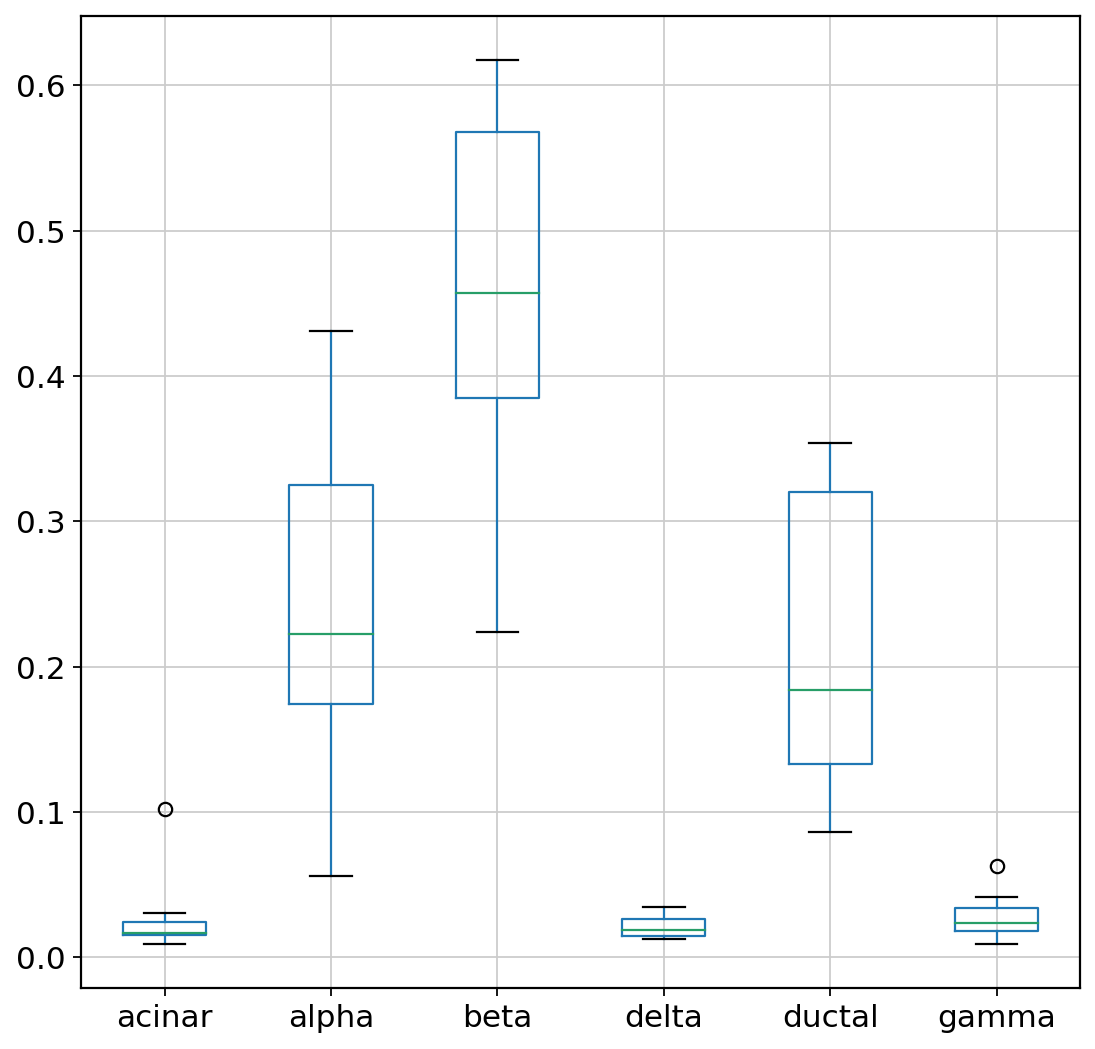

In [22]:
est_df.boxplot(figsize=(8,8))

In [16]:
true_df = pd.read_csv("../../data/xin/true.tsv", "\t", index_col=0)

/tmp/ipykernel_31698/1208660019.py:1: FutureWarning:

In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.



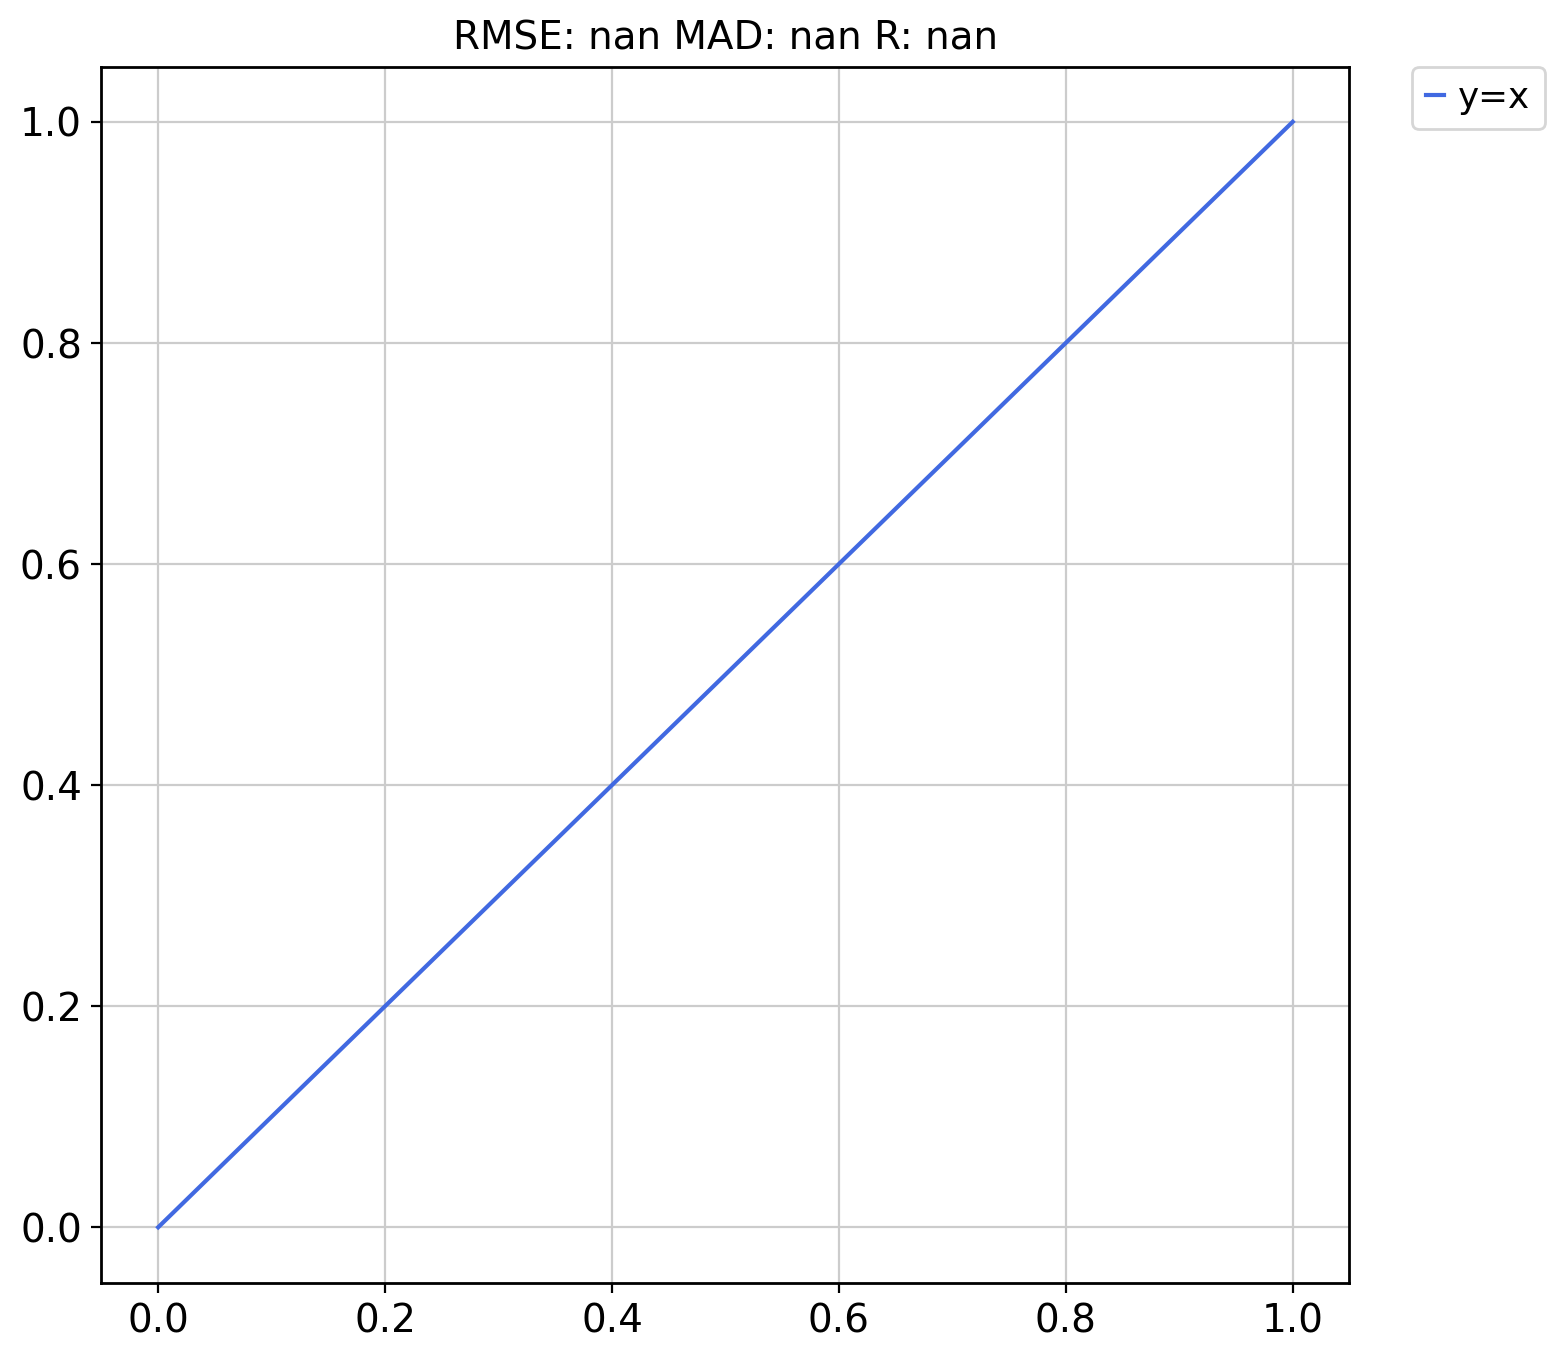

In [17]:
dv.pl.scatter_check(true_df, est_df, style="sample")

In [18]:
pd.DataFrame({
    "MuSiC": [0.10, 0.06, 0.94],
    "NNLS": [0.17, 0.12, 0.82],
    "BSEQ-sc": [0.21, 0.15, 0.79],
    "CIBERSORT": [0.21, 0.15, 0.76],
    "Normal": [0.16, 0.10, 0.79],
    "Poisson": [0.06, 0.05, 0.97]},
    index=["RMSD", "mAD", "R"]
)

,MuSiC,NNLS,BSEQ-sc,CIBERSORT,Normal,Poisson
RMSD,0.10,0.17,0.21,0.21,0.16,0.06
mAD,0.06,0.12,0.15,0.15,0.10,0.05
R,0.94,0.82,0.79,0.76,0.79,0.97
